In [1]:
!pip install --quiet -r requirements.txt

In [2]:
!nvidia-smi

Tue Nov 19 05:09:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P5             23W /  170W |     602MiB /  12288MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import warnings
warnings.filterwarnings('ignore')

import os, gc
import numpy as np
import pandas as pd
import polars as pl

#from hyperopt import hp, fmin, tpe, Trials
#from hyperopt.pyll.base import scope
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm
#from joblib import dump, load
#import datatable as dtable
#from mlxtend.evaluate import GroupTimeSeriesSplit
import kaggle_evaluation.jane_street_inference_server

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from torchvision import datasets
from torchvision.transforms import ToTensor
TEST=False


In [4]:
# check that torch is working and sees the GPU
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.4.1+cu121
True
NVIDIA GeForce RTX 3060


In [18]:
collected = gc.collect()
# Prints Garbage collector 
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)

Garbage collector: collected 15 objects.


# Load data

In [6]:
path = os.getcwd()
if TEST:
    df1 = pl.read_parquet(path+'/input/train.parquet/partition_id=0/part-0.parquet')
    df2 = pl.read_parquet(path+'/input/train.parquet/partition_id=1/part-0.parquet')
    df3 = pl.read_parquet(path+'/input/train.parquet/partition_id=2/part-0.parquet')
    train = pl.concat([df1,df2,df3])
    del df1, df2, df3

else:
    # very important to optimize memory when loading the full damn thing
    cols = ['date_id', 'time_id', 'weight']
    cols.extend(['feature_{:02d}'.format(num) for num in range(0, 79)])
    cols.append('responder_6')
    df1 = pl.read_parquet(path+'/input/train.parquet/partition_id=0/part-0.parquet', columns=cols)
    df2 = pl.read_parquet(path+'/input/train.parquet/partition_id=1/part-0.parquet', columns=cols)
    df3 = pl.read_parquet(path+'/input/train.parquet/partition_id=2/part-0.parquet', columns=cols)
    df4 = pl.read_parquet(path+'/input/train.parquet/partition_id=3/part-0.parquet', columns=cols)
    df5 = pl.read_parquet(path+'/input/train.parquet/partition_id=4/part-0.parquet', columns=cols)
    df6 = pl.read_parquet(path+'/input/train.parquet/partition_id=5/part-0.parquet', columns=cols)
    df7 = pl.read_parquet(path+'/input/train.parquet/partition_id=6/part-0.parquet', columns=cols)
    df8 = pl.read_parquet(path+'/input/train.parquet/partition_id=7/part-0.parquet', columns=cols)
    df9 = pl.read_parquet(path+'/input/train.parquet/partition_id=8/part-0.parquet', columns=cols)
    df10 = pl.read_parquet(path+'/input/train.parquet/partition_id=9/part-0.parquet', columns=cols)
    train = pl.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])
    del df1, df2, df3, df4, df5, df6, df7, df8, df9, df10

gc.collect()

0

In [7]:
features = [c for c in train.columns if 'feature' in c]
#features.append('weight')
#features.append('time_id')
#features.append('symbol_id')
target = 'responder_6'
print(train.shape)
print(train.columns)
print(train[features].null_count())
# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
# Prints Garbage collector 
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)

# note to self, incorporate features.csv true/false tables at some point 

(47127338, 83)
['date_id', 'time_id', 'weight', 'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 

# Preprocessing

In [8]:
print('Filling...')
# next two lines were for pandas not polars
#f_mean = train[features].mean() 
# print(train.weight.gt(0).sum() == train.shape[0]) # check if weights>0 is true for entire dataframe
print(train.shape)
train = train.fill_null(0)
#train.dropna(inplace=True)
print(train.null_count())

Filling...
(47127338, 83)
shape: (1, 83)
┌─────────┬─────────┬────────┬────────────┬───┬────────────┬────────────┬────────────┬─────────────┐
│ date_id ┆ time_id ┆ weight ┆ feature_00 ┆ … ┆ feature_76 ┆ feature_77 ┆ feature_78 ┆ responder_6 │
│ ---     ┆ ---     ┆ ---    ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---         │
│ u32     ┆ u32     ┆ u32    ┆ u32        ┆   ┆ u32        ┆ u32        ┆ u32        ┆ u32         │
╞═════════╪═════════╪════════╪════════════╪═══╪════════════╪════════════╪════════════╪═════════════╡
│ 0       ┆ 0       ┆ 0      ┆ 0          ┆ … ┆ 0          ┆ 0          ┆ 0          ┆ 0           │
└─────────┴─────────┴────────┴────────────┴───┴────────────┴────────────┴────────────┴─────────────┘


In [9]:
# for the purged group time series split, code is copied from somewhere
# TODO: make GitHub GIST
# TODO: add as dataset
# TODO: add logging with verbose

from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.|
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
# from matplotlib.colors import ListedColormap
    
# # this is code slightly modified from the sklearn docs here:
# # https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
# def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
#     """Create a sample plot for indices of a cross-validation object."""
    
#     cmap_cv = plt.cm.coolwarm

#     jet = plt.cm.get_cmap('jet', 256)
#     seq = np.linspace(0, 1, 256)
#     _ = np.random.shuffle(seq)   # inplace
#     cmap_data = ListedColormap(jet(seq))

#     # Generate the training/testing visualizations for each CV split
#     for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
#         # Fill in indices with the training/test groups
#         indices = np.array([np.nan] * len(X))
#         indices[tt] = 1
#         indices[tr] = 0

#         # Visualize the results
#         ax.scatter(range(len(indices)), [ii + .5] * len(indices),
#                    c=indices, marker='_', lw=lw, cmap=cmap_cv,
#                    vmin=-.2, vmax=1.2)

#     # Plot the data classes and groups at the end
#     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
#                c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

#     ax.scatter(range(len(X)), [ii + 2.5] * len(X),
#                c=group, marker='_', lw=lw, cmap=cmap_data)

#     # Formatting
#     yticklabels = list(range(n_splits)) + ['target', 'day']
#     ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
#            xlabel='Sample index', ylabel="CV iteration",
#            ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
#     ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
#     return ax


# fig, ax = plt.subplots()
# #plot_cv_indices(cv, X_train, y_train, groups, ax, 5, lw=20)
# plot_cv_indices(
#     cv,
#     train[features].values,
#     train['responder_6'].values,
#     train['date_id'].values,
#     ax,
#     5,
#     lw=20
# )
# rubbish=gc.collect()

# code structure copied from good tutorial: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

In [19]:
### Define model and various functions

# get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

# for monitoring layer weights
def weight_histograms(writer, step, model):
    print("Visualizing model weights...")
    # Iterate over all model layers
    for layer_number in range(len(model.layers)):
        layer = model.layers[layer_number]
        try:
            weights = layer.weight
            flattened_weights = weights.flatten()
            tag = f"layer_{layer_number}"
            writer.add_histogram(tag, flattened_weights, global_step=step, bins='tensorflow')
        except AttributeError:
            return
            
# loss is as defined on competition homepage
def my_loss(outputs, targets, weights):
    loss = torch.sum(weights*(targets - outputs)**2) / torch.sum(weights*targets**2)
    return loss

# "standard" loss function
test_loss_function= nn.MSELoss()
#test_loss_function = nn.L1Loss()

class MLP(nn.Module):
    '''
    Simple Neural Network/MultiLayer Perceptron
    '''
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_rates):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_rates = dropout_rates
        current_dim = input_dim
        self.layers = nn.ModuleList()
        self.layers.append(nn.BatchNorm1d(current_dim))
        self.layers.append(nn.Dropout(dropout_rates[0]))
        for i in range(len(hidden_dim)):
            self.layers.append(nn.Linear(current_dim, self.hidden_dim[i]))
            self.layers.append(nn.BatchNorm1d(self.hidden_dim[i]))
            self.layers.append(nn.SiLU())
            self.layers.append(nn.Dropout(self.dropout_rates[i+1]))
            current_dim = self.hidden_dim[i]
        self.layers.append(nn.Linear(current_dim, self.output_dim))

        self.seq = nn.Sequential(*self.layers)
        
    def forward(self, x):
        '''Forward pass'''
        return self.seq(x)


Using cuda device


In [20]:
### Configuration options
folds = 10
num_epochs = 10
test_loss = False
# For fold results
results = {}

# Set fixed random number seed
#torch.manual_seed(42)

# Define the PurgedGroupTimeSeriesCV
cv = PurgedGroupTimeSeriesSplit(
n_splits=folds,
max_train_group_size=150,
group_gap=30,
max_test_group_size=30
)

# extract needed parameters from dataframe as np arrays, will later turn into tensors
X = train[features].to_numpy()
y = train['responder_6'].to_numpy()
group = train['date_id'].to_numpy()
w = train['weight'].to_numpy()

# Define the neural network parameters
input_dim = len(features) 
output_dim = 1
#hidden_dim = [32, 64, 64, 32, 8]
hidden_dim = [128, 256, 256, 128, 64]
#hidden_dim = [384, 896, 896, 394, 128]
#dropout_rates = [0.01,0.01,0.01,0.01]
dropout_rates=[0.1,0.1,0.1,0.1, 0.1, 0.1]*2
learning_rate = 1e-4
print('--------------------------------')

# neat hack to ensure the original dataframe is gone
del train
gc.collect()
train = pd.DataFrame()

--------------------------------


In [21]:
### Train and cross validation loop
for fold, (train_ids, test_ids) in enumerate(cv.split(X=X, y=y, groups=group)):

    # Print
    print(f'FOLD {fold}')
    print(f'train_ids: [{train_ids[0]}, {train_ids[-1]}]')
    print(f'test_ids: [{test_ids[0]}, {test_ids[-1]}]')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    # does this make sense for a time series?... I don't think so
    #train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    #test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # define train/test sets
    X_tr, y_tr, w_tr = X[train_ids], y[train_ids], w[train_ids]
    X_te, y_te, w_te = X[test_ids], y[test_ids], w[test_ids]
    # Initialize Dataset objects to make PyTorch play nice
    trainset = TensorDataset(torch.tensor(X_tr), torch.tensor(y_tr), torch.tensor(w_tr))
    testset = TensorDataset(torch.tensor(X_te), torch.tensor(y_te), torch.tensor(w_te))
    
    # Define data loaders
    BATCH_SIZE = 4096
    NUM_WORKERS = 4 # num of parallel subprocesses for data loading (CPU task)
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BATCH_SIZE,
        num_workers = NUM_WORKERS
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BATCH_SIZE,
        num_workers = NUM_WORKERS
    )

    # Init the neural network
    network = MLP(input_dim, output_dim, hidden_dim, dropout_rates).to(device) # .to(device) sends model to GPU
    network.apply(reset_weights) # not sure if I need this but w/e
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    network.train()

    batch_train_tally = 0
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Visualize weight histograms
        weight_histograms(writer, epoch, network)
        
        # Print epoch
        print(f'Starting epoch {epoch+1}')
        
        # Set current loss value
        current_loss = 0.0

        # Iterate over Dataloader for training data
        for i, data in enumerate(trainloader):

            # Get inputs
            inputs, targets, weights = data
            inputs = inputs.to(device) # GPU must see the data and the model
            targets = targets.to(device)
            weights = weights.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Perform forward pass
            outputs = network(inputs)
            
            # Compute loss
            if test_loss:
                loss = test_loss_function(outputs[:,0], targets)
            else:
                loss = my_loss(outputs[:,0], targets, weights)
            writer.add_scalar("Loss/train/minibatches", loss, batch_train_tally)
            batch_train_tally += 1
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            # Print statistics
            current_loss += loss.item()
            if i % 1000 == 999:
                print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, current_loss / 1000))
                current_loss = 0.0

        # Finished iterating over Dataloader
        writer.add_scalar("Loss/train/epoch", loss, epoch)
        writer.flush()
    
    # Process is complete.
    print('Training process has finished')
    
    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluation for this fold
    R2_score = 0.0
    total_loss = 0.0
    batch_test_tally = 0
    with torch.no_grad():
        network.eval()
        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader):
            # Get inputs
            inputs, targets, weights = data
            inputs = inputs.to(device) # GPU must see the data and the model
            targets = targets.to(device)
            weights = weights.to(device)
        
            # Generate outputs
            outputs = network(inputs)
            if test_loss:
                loss = test_loss_function(outputs[:,0], targets)
            else:
                 loss = my_loss(outputs[:,0], targets, weights)

            writer.add_scalar('Loss/test/minibatches', loss, batch_test_tally)
            batch_test_tally += 1
            
            total_loss += loss

        print('--------------------------------')
        num_batches = len(testloader)
        results[fold] = total_loss / num_batches
        writer.add_scalar('Loss/test/fold', results[fold], fold)
        writer.flush()
    
    # Print fold results
    print(f'CROSS VALIDATION RESULTS FOR {folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value}')
        sum += value
    print(f'Average: {sum/len(results.items())}')
writer.close()
rubbish=gc.collect()

FOLD 0
train_ids: [29443914, 35051537]
test_ids: [36098944, 37195657]
--------------------------------
Reset trainable parameters of layer = BatchNorm1d(79, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=79, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=256, bias=True)
Reset trainable parameters of layer = BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=256, bias=True)
Reset trainable parameters of layer = BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=

-0.26465315


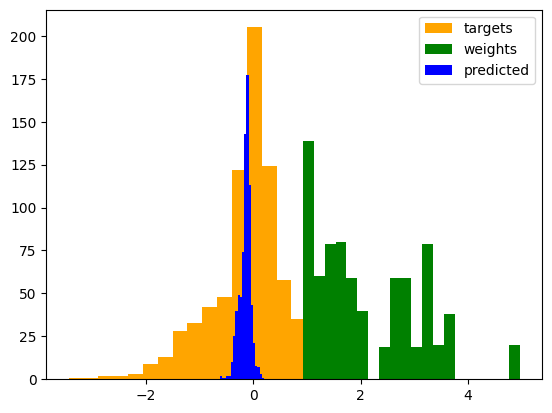

In [22]:
# lmao
out = outputs.cpu().detach().numpy()
tar = targets.cpu().detach().numpy()
wei = weights.cpu().detach().numpy()
print(out[10,0])
nbins = 20
plt.hist(tar, color='orange', label='targets', bins=nbins)
plt.hist(wei, color='green', label='weights', bins=nbins)
plt.hist(out[:,0], color='blue', bins=nbins, label='predicted')
plt.legend()